In [1]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:          26073         705       22651           1        2715       24990
Swap:             0           0           0


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os, sys
cwd = '/content/drive/MyDrive/Competitions/SIGIR/SIGIR-ecom-data-challenge-main/submission/007_stage2_mf_rnn_02/'
os.chdir(cwd)

In [5]:
import argparse
import gc
import pickle as pkl
import random
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
from sklearn.model_selection import GroupKFold
from torch.utils.data import DataLoader
from tqdm import tqdm

sys.path.append("../util")
from lstm import lstm_model
from utils import reduce_df, save_checkpoint, test_epoch

In [ ]:
fname = 'model_mf'

checkpoint_path = Path('./checkpoints/mf')

#input_path = Path('D:/SIGIR/train/')
input_path = Path('/content/drive/MyDrive/Data_Competitions/SIGIR2021/')

In [7]:
pd.options.display.max_columns = 100

# model of RNN

In [9]:
N_FOLD = 5

In [10]:
MAX_EMBED_DIM = 256
HIDDEN_DIM = 512

In [11]:
with open(input_path / 'mappings_rnn_stage2.pkl', mode='rb') as f:
    mappings_RNN = pkl.load(f)
mappings_RNN

[Index(['bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4adefbe55239b3817fdf5',
        'e1d919d93793d553de030e9f6c7524a7db96f5b459688152262a23d280a5b250',
        '9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d22b33ff9d581dd0d5e9',
        '379afa673527cf5b494a5b3c6decdbcd2e4b2247e1548527616d57c3bf2dfe74',
        'ba1b2d4fd7ed4d7add7d001ddfc173b6961d37c078eed067e8f4fcbece068ae4',
        '3823c0ae0866a92c93c18ba4af63169128edb0cd679affd5418e25084b121c61',
                                                                        -1,
        'fa2f22b63f20f974310deec8da2c76b6fb0057683a0ceaf037b861fea82069e0',
        '409308a78b45af2d988eef583eb35a80cb5c89f294f77111a41a5af22e7e9592',
        '3c96575eab701b1a4d99d1a8718f115eb27fd51c7e3f77c85607e3a62d6da573',
        ...
        '6410e74d501f3cc209a2ed9204a780116906e49a6f0eb8ac66ff58556dfb1eda',
        'df58ba01f6ea298d26631ff52a718f4e4c6cf3704ea40afa2b52d0f50d23cf78',
        'ea24954ad8183a479871bf03220dfcd795f4afa653361f6599b2625ae125f33a',


In [12]:
%%time
all_df = pd.read_csv(input_path / 'inputdf_meta_rnn_stage2.csv')
all_df = all_df.rename(columns={'category_hash_id': 'category_lag0'})
print(all_df.shape)

(9853698, 62)
CPU times: user 36.1 s, sys: 7.29 s, total: 43.4 s
Wall time: 46.9 s


In [13]:
test_RNN = all_df.loc[(all_df.is_test==1) & (all_df.cum_product_r==0)].copy()
print(test_RNN.shape)
test_RNN.head()

(224662, 62)


,is_test,SessionId,cum_product_r,product_hash_lag0,category_lag0,product_action_id,cum_pageview_id,cum_product_id,cum_search_id,cum_event_id,num_following_search_id,num_following_pageview_id,price_bucket_id,price_null_id,dayofweek_id,hour_id,weekend_id,num_search_id,num_pageview_id,product_hash_lag1,product_hash_lag2,product_hash_lag3,product_hash_lag4,product_hash_lag5,product_hash_lag6,product_hash_lag7,product_hash_lag8,product_hash_lag9,product_hash_lag10,product_hash_lag11,product_hash_lag12,product_hash_lag13,product_hash_lag14,product_hash_lag15,product_hash_lag16,product_hash_lag17,product_hash_lag18,product_hash_lag19,category_lag1,category_lag2,category_lag3,category_lag4,category_lag5,category_lag6,category_lag7,category_lag8,category_lag9,category_lag10,category_lag11,category_lag12,category_lag13,category_lag14,category_lag15,category_lag16,category_lag17,category_lag18,category_lag19,first_product,first_category,first_url,next_product,fold
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,0,0,0,6,2
2,1,1,0,2,1,0,0,1,0,1,0,0,1,0,1,1,0,0,0,1,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,1,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,1,1,1,6,3
6,1,2,0,6,2,0,4,3,0,5,0,1,2,0,2,2,1,0,2,5,4,3,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,3,2,2,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,3,2,3,6,4
7,1,3,0,7,4,0,5,0,0,6,0,0,1,0,0,3,0,0,4,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,7,4,7,6,0
8,1,4,0,8,1,0,0,0,0,0,0,0,1,0,3,4,0,0,0,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,8,1,8,6,1


In [14]:
target_count = all_df['next_product'].max() + 1
target_count

27842

In [15]:
LAGS = 19
lag_targets = []

for i in range(LAGS, -1, -1):
    lag_targets.append(f'product_hash_lag{i}')

lag_targets

['product_hash_lag19',
 'product_hash_lag18',
 'product_hash_lag17',
 'product_hash_lag16',
 'product_hash_lag15',
 'product_hash_lag14',
 'product_hash_lag13',
 'product_hash_lag12',
 'product_hash_lag11',
 'product_hash_lag10',
 'product_hash_lag9',
 'product_hash_lag8',
 'product_hash_lag7',
 'product_hash_lag6',
 'product_hash_lag5',
 'product_hash_lag4',
 'product_hash_lag3',
 'product_hash_lag2',
 'product_hash_lag1',
 'product_hash_lag0']

In [16]:
LAGS_CATEGORY = 19
lag_categories = []

for i in range(LAGS_CATEGORY, -1, -1):
    lag_categories.append(f'category_lag{i}')

lag_categories

['category_lag19',
 'category_lag18',
 'category_lag17',
 'category_lag16',
 'category_lag15',
 'category_lag14',
 'category_lag13',
 'category_lag12',
 'category_lag11',
 'category_lag10',
 'category_lag9',
 'category_lag8',
 'category_lag7',
 'category_lag6',
 'category_lag5',
 'category_lag4',
 'category_lag3',
 'category_lag2',
 'category_lag1',
 'category_lag0']

In [17]:
FEATURES = ['product_action_id',
            'cum_pageview_id', 'cum_product_id', 'cum_search_id', 'cum_event_id',
            'num_following_search_id', 'num_following_pageview_id',
            'price_bucket_id', 'price_null_id', 'dayofweek_id', 'hour_id', 'first_url', 
            'weekend_id', 'num_search_id', 'num_pageview_id', 'first_product', 'first_category'] + lag_targets + lag_categories# + lag_urls

In [18]:
value_counts = []
for c in FEATURES:
    max_ = all_df[c].max()
    value_counts.append(max_+1)
    print(c, max_+1)
embed_dims = [max(1, min(int((n+2)*0.25), MAX_EMBED_DIM)) for n in value_counts]
embedding_map = {i:(j, k) for i, j, k in zip(FEATURES, value_counts, embedding_dims)}
embedding_map

product_action_id 4
cum_pageview_id 173
cum_product_id 188
cum_search_id 61
cum_event_id 212
num_following_search_id 37
num_following_pageview_id 105
price_bucket_id 10
price_null_id 2
dayofweek_id 7
hour_id 24
first_url 28673
weekend_id 2
num_search_id 34
num_pageview_id 98
first_product 27841
first_category 174
product_hash_lag19 27843
product_hash_lag18 27843
product_hash_lag17 27843
product_hash_lag16 27843
product_hash_lag15 27843
product_hash_lag14 27843
product_hash_lag13 27843
product_hash_lag12 27843
product_hash_lag11 27843
product_hash_lag10 27843
product_hash_lag9 27843
product_hash_lag8 27843
product_hash_lag7 27843
product_hash_lag6 27843
product_hash_lag5 27843
product_hash_lag4 27843
product_hash_lag3 27843
product_hash_lag2 27843
product_hash_lag1 27843
product_hash_lag0 27842
category_lag19 175
category_lag18 175
category_lag17 175
category_lag16 175
category_lag15 175
category_lag14 175
category_lag13 175
category_lag12 175
category_lag11 175
category_lag10 175
categ

{'category_lag0': (174, 44),
 'category_lag1': (175, 44),
 'category_lag10': (175, 44),
 'category_lag11': (175, 44),
 'category_lag12': (175, 44),
 'category_lag13': (175, 44),
 'category_lag14': (175, 44),
 'category_lag15': (175, 44),
 'category_lag16': (175, 44),
 'category_lag17': (175, 44),
 'category_lag18': (175, 44),
 'category_lag19': (175, 44),
 'category_lag2': (175, 44),
 'category_lag3': (175, 44),
 'category_lag4': (175, 44),
 'category_lag5': (175, 44),
 'category_lag6': (175, 44),
 'category_lag7': (175, 44),
 'category_lag8': (175, 44),
 'category_lag9': (175, 44),
 'cum_event_id': (212, 53),
 'cum_pageview_id': (173, 43),
 'cum_product_id': (188, 47),
 'cum_search_id': (61, 15),
 'dayofweek_id': (7, 2),
 'first_category': (174, 44),
 'first_product': (27841, 256),
 'first_url': (28673, 256),
 'hour_id': (24, 6),
 'num_following_pageview_id': (105, 26),
 'num_following_search_id': (37, 9),
 'num_pageview_id': (98, 25),
 'num_search_id': (34, 9),
 'price_bucket_id': (1

In [77]:
models_RNN = []
for k in range(N_FOLD):
    model = lstm_model(FEATURES, embedding_map, MAX_EMBED_DIM, HIDDEN_DIM, target_count)
    name = f'./checkpoints/rnn/LSTM_{k}.h5'
    print(name)
    model.load_weights(name)
    models_RNN.append(model)

./checkpoints/rnn/MLPx_fold0.h5
./checkpoints/rnn/MLPx_fold1.h5
./checkpoints/rnn/MLPx_fold2.h5
./checkpoints/rnn/MLPx_fold3.h5
./checkpoints/rnn/MLPx_fold4.h5


In [20]:
del all_df

In [78]:
gc.collect()

122597

# MF models

In [22]:
%%time
all_df = pd.read_csv(input_path / 'input_product_mf.csv')
print(all_df.shape)

(9853698, 108)
CPU times: user 1min 48s, sys: 21.8 s, total: 2min 10s
Wall time: 2min 15s


In [23]:
%%time
reduce_df(all_df)
all_df.dtypes

CPU times: user 1min 34s, sys: 14.7 s, total: 1min 48s
Wall time: 1min 48s


In [24]:
to_int8 = ['is_test', 'fold', 'dayofweek', 'hour', 'weekend', 'price_null', 'description_null', 'img_null']
for c in to_int8:
    all_df[c] = all_df[c].astype(np.int8)

In [25]:
for c in all_df.columns:
    print(c, ': ', all_df[c].dtypes)

is_test :  int8
SessionId :  int32
last_event_length :  float32
cum_pageview :  float32
cum_product :  float32
cum_search :  float32
cum_event :  float32
lapse :  float32
cum_product_r :  int32
num_following_search :  float32
num_following_pageview :  float32
price_bucket :  float32
description_0 :  float32
description_1 :  float32
description_2 :  float32
description_3 :  float32
img_0 :  float32
img_1 :  float32
img_2 :  float32
img_3 :  float32
price_null :  int8
description_null :  int8
img_null :  int8
product_count :  float32
category_hash_count :  float32
hashed_url_count :  float32
product_hash_lag0 :  int32
category_hash_id :  int32
product_action_id :  int32
hashed_url_id :  int32
product_hash_lag1 :  int32
product_hash_lag2 :  int32
product_hash_lag3 :  int32
product_hash_lag4 :  int32
product_hash_lag5 :  int32
product_hash_lag6 :  int32
product_hash_lag7 :  int32
product_hash_lag8 :  int32
product_hash_lag9 :  int32
product_hash_lag10 :  int32
product_hash_lag11 :  int32
p

In [26]:
LAGS = 19
lag_products = []

for i in range(LAGS+1):
    lag_products.append(f'product_hash_lag{i}')

lag_products

['product_hash_lag0',
 'product_hash_lag1',
 'product_hash_lag2',
 'product_hash_lag3',
 'product_hash_lag4',
 'product_hash_lag5',
 'product_hash_lag6',
 'product_hash_lag7',
 'product_hash_lag8',
 'product_hash_lag9',
 'product_hash_lag10',
 'product_hash_lag11',
 'product_hash_lag12',
 'product_hash_lag13',
 'product_hash_lag14',
 'product_hash_lag15',
 'product_hash_lag16',
 'product_hash_lag17',
 'product_hash_lag18',
 'product_hash_lag19']

In [27]:
LAGS_CATEGORY = 19
lag_categories = []

for i in range(LAGS_CATEGORY+1):
    lag_categories.append(f'category_lag{i}')

In [28]:
LAGS_URL = 19
lag_urls = []

for i in range(LAGS_URL+1):
    lag_urls.append(f'url_lag{i}')

In [29]:
LAGS_VECTOR = 1
lag_descriptions = []
lag_imgs = []

for k in range(4):
    for i in range(LAGS_VECTOR+1):
        lag_descriptions.append(f'description_{k}_lag{i}')
        lag_imgs.append(f'img_{k}_lag{i}')

In [30]:
list_rename = ['description_0', 'description_1', 'description_2', 'description_3', 'img_0', 'img_1', 'img_2', 'img_3']
dict_rename = {k: k + '_lag0' for k in list_rename}
dict_rename['category_hash_id'] = 'category_lag0'
dict_rename['hashed_url_id'] = 'url_lag0'
all_df = all_df.rename(columns=dict_rename)

In [31]:
usecols = ['last_event_length', 'cum_pageview',
       'cum_product', 'cum_search', 'cum_event', 'lapse',
       'num_following_search', 'num_following_pageview',
       'price_bucket', 'price_null', 'description_null',
       'img_null', 'product_count',
       'product_action_id', 'first_product',
       'dayofweek', 'hour', 'weekend', 'cum_search_last', 'num_search',
       'cum_pageview_last', 'num_pageview', 'first_category', 'first_url',
       'category_hash_count', 'hashed_url_count']
usecols += ['lag_products', 'lag_categories', 'lag_urls', 'lag_descriptions', 'lag_imgs']
usecols

['last_event_length',
 'cum_pageview',
 'cum_product',
 'cum_search',
 'cum_event',
 'lapse',
 'num_following_search',
 'num_following_pageview',
 'price_bucket',
 'price_null',
 'description_null',
 'img_null',
 'product_count',
 'product_action_id',
 'first_product',
 'dayofweek',
 'hour',
 'weekend',
 'cum_search_last',
 'num_search',
 'cum_pageview_last',
 'num_pageview',
 'first_category',
 'first_url',
 'category_hash_count',
 'hashed_url_count',
 'lag_products',
 'lag_categories',
 'lag_urls',
 'lag_descriptions',
 'lag_imgs']

In [32]:
from dataset_ import SigirDataset

In [33]:
with open(input_path / 'mappings_stage2.pkl', mode='rb') as f:
    mappings = pkl.load(f)
mappings

[Index(['bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4adefbe55239b3817fdf5',
        'e1d919d93793d553de030e9f6c7524a7db96f5b459688152262a23d280a5b250',
        '9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d22b33ff9d581dd0d5e9',
        '379afa673527cf5b494a5b3c6decdbcd2e4b2247e1548527616d57c3bf2dfe74',
        'ba1b2d4fd7ed4d7add7d001ddfc173b6961d37c078eed067e8f4fcbece068ae4',
        '3823c0ae0866a92c93c18ba4af63169128edb0cd679affd5418e25084b121c61',
                                                                        -1,
        'fa2f22b63f20f974310deec8da2c76b6fb0057683a0ceaf037b861fea82069e0',
        '409308a78b45af2d988eef583eb35a80cb5c89f294f77111a41a5af22e7e9592',
        '3c96575eab701b1a4d99d1a8718f115eb27fd51c7e3f77c85607e3a62d6da573',
        ...
        '6410e74d501f3cc209a2ed9204a780116906e49a6f0eb8ac66ff58556dfb1eda',
        'df58ba01f6ea298d26631ff52a718f4e4c6cf3704ea40afa2b52d0f50d23cf78',
        'ea24954ad8183a479871bf03220dfcd795f4afa653361f6599b2625ae125f33a',


In [34]:
LOW_PRODUCTS = np.where(mappings[0] == -1)[0][0]
LOW_PRODUCTS

6

In [35]:
from nn_ import MLP

In [36]:
os.cpu_count()

4

In [37]:
TEST_BATCH_SIZE = 256
WORKERS = os.cpu_count()
EMBEDDING_DIM = 64
HIDDEN_DIM =  1024
DROPOUT_RATE = 0.2
device = torch.device('cuda')

In [39]:
gc.collect()

450

In [40]:
NUM_PRODUCTS = all_df.product_hash_lag0.max() + 1
NUM_PRODUCTS

27842

In [41]:
NUM_CATEGORIES = all_df['category_lag0'].max() + 1
NUM_CATEGORIES

174

In [42]:
NUM_URLS = all_df['url_lag0'].max() + 1
NUM_URLS

28683

In [43]:
def load_checkpoint(fold, seed, device, fname, loss=False):
    model = MLP(NUM_PRODUCTS+1, 
            NUM_CATEGORIES+1, 
            NUM_URLS+1, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            dropout_rate=DROPOUT_RATE, 
            loss=loss,
            lag_targets=lag_products, 
            lag_categories=lag_categories, 
            lag_urls=lag_urls, 
            low_targets=LOW_PRODUCTS).to(device)
    checkpoint = torch.load('./checkpoints/mf-rec/%s_%d_%d.pt' % (fname, fold, seed),
                            map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model'])
    model.eval()
    return model

In [44]:
NFOLDS = 5
seed = 0
models = [load_checkpoint(fold, seed, device, fname) for fold in range(NFOLDS)]

product embedding data shape torch.Size([27843, 64])
category embedding data shape torch.Size([175, 64])
product embedding data shape torch.Size([27843, 64])
category embedding data shape torch.Size([175, 64])
product embedding data shape torch.Size([27843, 64])
category embedding data shape torch.Size([175, 64])
product embedding data shape torch.Size([27843, 64])
category embedding data shape torch.Size([175, 64])
product embedding data shape torch.Size([27843, 64])
category embedding data shape torch.Size([175, 64])


## test data

In [45]:
TARGET = 'next_product'

In [46]:
test = all_df.loc[(all_df.is_test==1) & (all_df.cum_product_r==0)].copy()
print(test.shape)
test

(224662, 108)


,is_test,SessionId,last_event_length,cum_pageview,cum_product,cum_search,cum_event,lapse,cum_product_r,num_following_search,num_following_pageview,price_bucket,description_0_lag0,description_1_lag0,description_2_lag0,description_3_lag0,img_0_lag0,img_1_lag0,img_2_lag0,img_3_lag0,price_null,description_null,img_null,product_count,category_hash_count,hashed_url_count,product_hash_lag0,category_lag0,product_action_id,url_lag0,product_hash_lag1,product_hash_lag2,product_hash_lag3,product_hash_lag4,product_hash_lag5,product_hash_lag6,product_hash_lag7,product_hash_lag8,product_hash_lag9,product_hash_lag10,product_hash_lag11,product_hash_lag12,product_hash_lag13,product_hash_lag14,product_hash_lag15,product_hash_lag16,product_hash_lag17,product_hash_lag18,product_hash_lag19,category_lag1,...,category_lag10,category_lag11,category_lag12,category_lag13,category_lag14,category_lag15,category_lag16,category_lag17,category_lag18,category_lag19,url_lag1,url_lag2,url_lag3,url_lag4,url_lag5,url_lag6,url_lag7,url_lag8,url_lag9,url_lag10,url_lag11,url_lag12,url_lag13,url_lag14,url_lag15,url_lag16,url_lag17,url_lag18,url_lag19,description_0_lag1,description_1_lag1,description_2_lag1,description_3_lag1,img_0_lag1,img_1_lag1,img_2_lag1,img_3_lag1,first_product,first_category,first_url,dayofweek,hour,weekend,cum_search_last,num_search,cum_pageview_last,num_pageview,next_product,next_next_product,fold
0,1,0,-0.318374,-1.294394,0.000000,-0.101426,-1.430364,-4.723478,0,0.0,0.0,0.227363,1.593151,1.384917,1.339295,0.021085,1.578851e+00,-1.527748e+00,5.877905e-01,5.028797e-01,0,0,0,2.529928,1.075753,2.316170,0,0,0,0,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,174,...,174,174,174,174,174,174,174,174,174,174,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,1,16,0,-0.083016,-0.020465,-1.079889,-0.385034,6,6,2
2,1,1,0.515448,-1.294394,0.405465,-0.101426,-1.024899,-1.163569,0,0.0,0.0,-1.113022,1.342221,-1.081300,0.668451,0.225876,-6.666954e-01,1.029353e+00,3.315532e-01,3.212282e-02,0,0,0,-1.368712,-0.266227,-1.588450,2,1,0,2,1,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,1,...,174,174,174,174,174,174,174,174,174,174,1,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,1.299976,-0.839638,1.121370,0.075403,-0.755082,0.471448,0.428078,-0.607161,1,1,1,4,3,0,-0.083016,-0.020465,-1.079889,-0.385034,6,6,3
6,1,2,0.642567,1.008191,0.916291,-0.101426,0.515546,0.644804,0,0.0,1.0,-0.219432,-0.731114,-1.400212,-0.661794,-1.016753,8.895090e-18,2.066455e-17,-5.549159e-18,-1.593524e-17,0,0,1,-5.127001,0.103984,-5.277329,6,2,0,6,5,4,3,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,3,...,174,174,174,174,174,174,174,174,174,174,5,4,3,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,-0.685361,-1.377530,-0.616998,-0.465234,0.312108,-0.991237,-0.122295,-1.057441,3,2,3,5,18,1,-0.083016,-0.020465,1.117335,0.308113,6,6,4
7,1,3,1.895251,0.315044,0.000000,-0.101426,-0.331752,2.619810,0,0.0,0.0,-1.113022,1.690798,0.623054,1.391895,-0.049847,1.288404e+00,-1.822939e+00,7.697510e-01,-7.824585e-01,0,0,0,-0.744974,1.694574,-0.968210,7,4,0,7,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,174,...,174,174,174,174,174,174,174,174,174,174,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,28683,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7,4,7,1,15,0,-0.083016,-0.020465,-1.079889,1.224404,6,6,0
8,1,4,-0.318374,-1.294394,0.000000,-0.101426,-1.430364,-4.723478,0,0.0,0.0,-1.113022,1.338992,-1.246590,0.975005,0.488979,-8.418654e

In [47]:
del all_df

In [76]:
!nvidia-smi

Thu Jun 17 22:06:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    40W / 300W |  10537MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [74]:
gc.collect()

443

In [75]:
torch.cuda.empty_cache()

In [52]:
def softmax_(x, max=None):
    x = x - x.max(1, keepdims=True)
    x = np.exp(x)
    x = x / x.sum(1, keepdims=True)
    return x

# Ensemble

In [79]:
N_TOP = 20
CHUNK = 1024 * WORKERS * 2
maxes = []

test_RNN.reset_index(drop=True,inplace=True)
top20 = np.zeros((test_RNN.shape[0], N_TOP))

for k in range(test_RNN.shape[0]//CHUNK + 1):
    begin = k * CHUNK
    end = (k+1) * CHUNK
    end = min(test_RNN.shape[0], end)
    preds_RNN = np.zeros((end - begin, t_ct))
    print('Chunk %i to %i'%(begin, end), flush=True)

    # RNN inference
    for fold in tqdm(range(N_FOLD)):
        test_ = test_RNN[FEATURES].iloc[begin:end].copy()       
        _, _, _, pred_fold = models_RNN[fold].predict(test_, verbose=0, batch_size=512)
        preds_RNN += pred_fold
    preds_RNN /= N_FOLD

    # mf inference
    test_dataset = SigirDataset(test.iloc[begin:end].copy(), 
                                usecols=usecols, 
                                lag_targets=lag_products, 
                                lag_categories=lag_categories, 
                                lag_urls=lag_urls, 
                                lag_descriptions=lag_descriptions, 
                                lag_imgs=lag_imgs, 
                                target='next_product')

    test_data_loader = DataLoader(
        test_dataset,
        batch_size=TEST_BATCH_SIZE,
        num_workers=WORKERS,
        shuffle=False,
        pin_memory=True,
    )
    preds_mlp_gpu = test_epoch(test_data_loader, models, device)
    preds_mlp = [pred.cpu().numpy() for pred in preds_mlp_gpu]
    preds_mlp = np.concatenate(preds_mlp)
    preds_mlp = preds_mlp[:,:-1]
    print('max:', preds_mlp.max())
    maxes.append(preds_mlp.max())
    preds_mlp = softmax_(preds_mlp)

    preds_mean = 0.5 * preds_RNN + 0.5 * preds_mlp
    preds_mean[:, LOW_PRODUCTS] = -1e10
    
    top20[begin:end] = preds_mean.argsort(axis=1)[:,-N_TOP:][:,::-1]

Chunk 0 to 8192


100%|██████████| 32/32 [00:03<00:00, 10.50it/s]


max: 34.283936
Chunk 8192 to 16384


100%|██████████| 32/32 [00:03<00:00, 10.34it/s]


max: 33.357063
Chunk 16384 to 24576


100%|██████████| 32/32 [00:03<00:00, 10.38it/s]


max: 32.0096
Chunk 24576 to 32768


100%|██████████| 32/32 [00:02<00:00, 10.68it/s]


max: 33.04288
Chunk 32768 to 40960


100%|██████████| 32/32 [00:03<00:00, 10.52it/s]


max: 35.156506
Chunk 40960 to 49152


100%|██████████| 32/32 [00:02<00:00, 11.14it/s]


max: 30.867779
Chunk 49152 to 57344


100%|██████████| 32/32 [00:03<00:00, 10.67it/s]


max: 37.115948
Chunk 57344 to 65536


100%|██████████| 32/32 [00:02<00:00, 10.73it/s]


max: 29.943054
Chunk 65536 to 73728


100%|██████████| 32/32 [00:02<00:00, 10.85it/s]


max: 34.021877
Chunk 73728 to 81920


100%|██████████| 32/32 [00:02<00:00, 10.87it/s]


max: 32.27768
Chunk 81920 to 90112


100%|██████████| 32/32 [00:02<00:00, 12.67it/s]


max: 39.20663
Chunk 90112 to 98304


100%|██████████| 32/32 [00:02<00:00, 12.71it/s]


max: 33.956932
Chunk 98304 to 106496


100%|██████████| 32/32 [00:02<00:00, 12.55it/s]


max: 32.42719
Chunk 106496 to 114688


100%|██████████| 32/32 [00:02<00:00, 12.49it/s]


max: 33.05052
Chunk 114688 to 122880


100%|██████████| 32/32 [00:02<00:00, 12.52it/s]


max: 31.932398
Chunk 122880 to 131072


100%|██████████| 32/32 [00:02<00:00, 12.31it/s]


max: 32.70316
Chunk 131072 to 139264


100%|██████████| 32/32 [00:02<00:00, 12.35it/s]


max: 36.676216
Chunk 139264 to 147456


100%|██████████| 32/32 [00:02<00:00, 12.73it/s]


max: 29.985357
Chunk 147456 to 155648


100%|██████████| 32/32 [00:02<00:00, 12.77it/s]


max: 30.774054
Chunk 155648 to 163840


100%|██████████| 32/32 [00:02<00:00, 12.55it/s]


max: 30.749817
Chunk 163840 to 172032


100%|██████████| 32/32 [00:02<00:00, 12.87it/s]


max: 33.117863
Chunk 172032 to 180224


100%|██████████| 32/32 [00:02<00:00, 13.11it/s]


max: 31.20414
Chunk 180224 to 188416


100%|██████████| 32/32 [00:02<00:00, 12.07it/s]


max: 33.29156
Chunk 188416 to 196608


100%|██████████| 32/32 [00:02<00:00, 12.61it/s]


max: 32.37091
Chunk 196608 to 204800


100%|██████████| 32/32 [00:02<00:00, 12.48it/s]


max: 32.67479
Chunk 204800 to 212992


100%|██████████| 32/32 [00:02<00:00, 12.79it/s]


max: 35.01051
Chunk 212992 to 221184


100%|██████████| 32/32 [00:02<00:00, 12.59it/s]


max: 32.265945
Chunk 221184 to 224662


100%|██████████| 14/14 [00:01<00:00,  8.31it/s]


max: 29.982565


In [80]:
import matplotlib.pyplot as plt

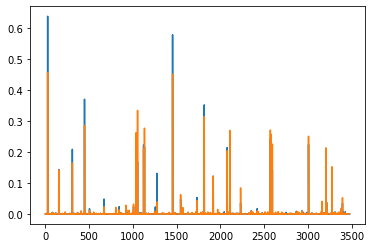

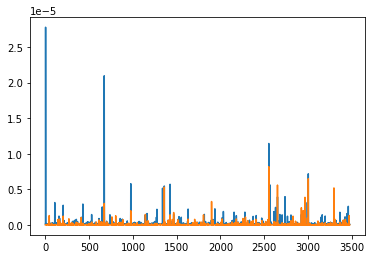

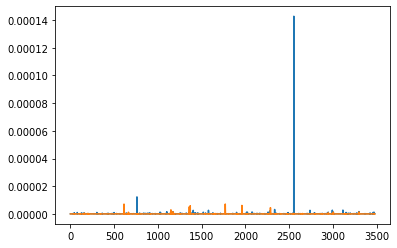

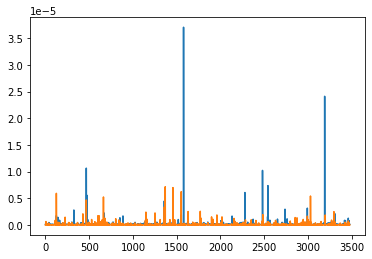

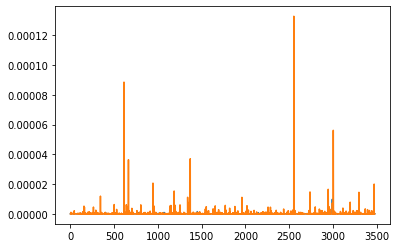

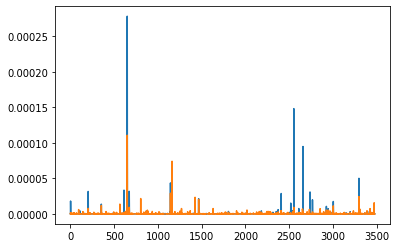

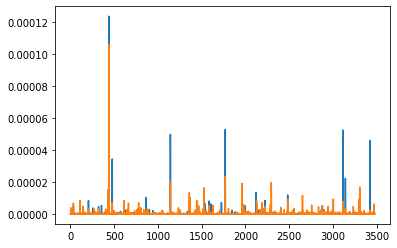

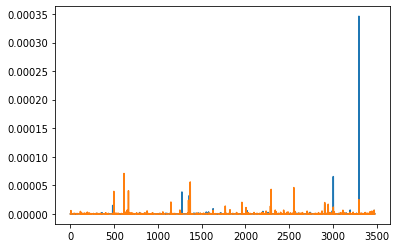

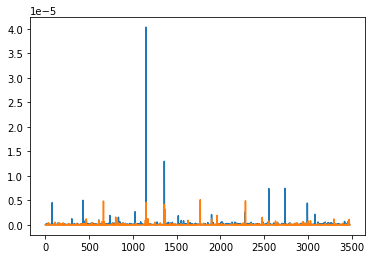

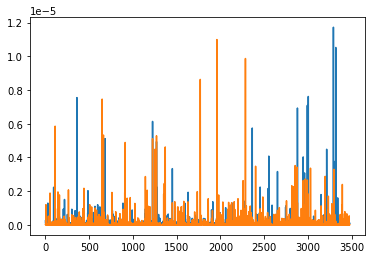

In [83]:
for i in range(10):
    plt.figure()
    plt.plot(preds_RNN[:,-i])
    plt.plot(preds_mlp[:,-i])

In [84]:
gc.collect()

53335

In [85]:
product_mapping = pd.DataFrame(mappings[0].values).reset_index()
product_mapping = product_mapping.rename(columns={0: 'product_sku_hash'})

In [86]:
product_mapping

,index,product_sku_hash
0,0,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...
1,1,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...
2,2,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...
3,3,379afa673527cf5b494a5b3c6decdbcd2e4b2247e15485...
4,4,ba1b2d4fd7ed4d7add7d001ddfc173b6961d37c078eed0...
...,...,...
27837,27837,2968a7904bf8c86b8f7e264a9fdf4a7bff2d670a56debd...
27838,27838,1d39cce946028415e1db14d5ad73376c89e65a7ec3d5da...
27839,27839,2f48761a0c81a85030b54521af0ada25fa68c3305f76b8...
27840,27840,8f8398763b2ca488ec77aebb0f9e9140a882cd57025029...


In [88]:
product_mapping_RNN = pd.DataFrame(mappings_RNN[0].values).reset_index()
product_mapping_RNN = product_mapping_RNN.rename(columns={0: 'product_sku_hash'})
product_mapping_RNN

,index,product_sku_hash
0,0,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...
1,1,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...
2,2,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...
3,3,379afa673527cf5b494a5b3c6decdbcd2e4b2247e15485...
4,4,ba1b2d4fd7ed4d7add7d001ddfc173b6961d37c078eed0...
...,...,...
27837,27837,2968a7904bf8c86b8f7e264a9fdf4a7bff2d670a56debd...
27838,27838,1d39cce946028415e1db14d5ad73376c89e65a7ec3d5da...
27839,27839,2f48761a0c81a85030b54521af0ada25fa68c3305f76b8...
27840,27840,8f8398763b2ca488ec77aebb0f9e9140a882cd57025029...


In [89]:
top20

array([[4.2500e+02, 0.0000e+00, 4.2600e+02, ..., 3.1150e+03, 1.9600e+02,
        8.0200e+02],
       [1.0730e+04, 1.0000e+00, 6.7640e+03, ..., 1.5660e+03, 1.0128e+04,
        3.1910e+03],
       [5.0000e+00, 4.0000e+00, 8.0730e+03, ..., 4.0140e+03, 2.2510e+03,
        5.2940e+03],
       ...,
       [5.5500e+02, 2.9200e+02, 2.8910e+03, ..., 1.6260e+03, 2.3290e+03,
        2.9900e+02],
       [7.4200e+02, 7.4100e+02, 2.5230e+03, ..., 1.8200e+02, 1.7550e+03,
        4.4260e+03],
       [6.0300e+02, 1.2110e+04, 1.4710e+03, ..., 8.9650e+03, 2.2730e+03,
        8.9100e+02]])

In [90]:
top20.shape

(224662, 20)

In [91]:
N_TOPK = 20
COLS = ['SessionId']

for k in range(N_TOPK):
    test[TARGET + '_%i'%(k+1)] = top20[:, k]
    tmp = test[[TARGET + '_%i'%(k+1)]].astype('int32').copy()
    tmp['sorting'] = np.asarray(range(tmp.shape[0]))
    tmp = tmp.merge(product_mapping, how='left', left_on=TARGET + '_%i'%(k+1), right_on='index')
    tmp = tmp.sort_values('sorting')
    test[TARGET + '_%i'%(k+1)] = tmp['product_sku_hash'].values.copy()
    COLS.append(TARGET + '_%i'%(k+1))

In [92]:
test.head()

,is_test,SessionId,last_event_length,cum_pageview,cum_product,cum_search,cum_event,lapse,cum_product_r,num_following_search,num_following_pageview,price_bucket,description_0_lag0,description_1_lag0,description_2_lag0,description_3_lag0,img_0_lag0,img_1_lag0,img_2_lag0,img_3_lag0,price_null,description_null,img_null,product_count,category_hash_count,hashed_url_count,product_hash_lag0,category_lag0,product_action_id,url_lag0,product_hash_lag1,product_hash_lag2,product_hash_lag3,product_hash_lag4,product_hash_lag5,product_hash_lag6,product_hash_lag7,product_hash_lag8,product_hash_lag9,product_hash_lag10,product_hash_lag11,product_hash_lag12,product_hash_lag13,product_hash_lag14,product_hash_lag15,product_hash_lag16,product_hash_lag17,product_hash_lag18,product_hash_lag19,category_lag1,...,url_lag11,url_lag12,url_lag13,url_lag14,url_lag15,url_lag16,url_lag17,url_lag18,url_lag19,description_0_lag1,description_1_lag1,description_2_lag1,description_3_lag1,img_0_lag1,img_1_lag1,img_2_lag1,img_3_lag1,first_product,first_category,first_url,dayofweek,hour,weekend,cum_search_last,num_search,cum_pageview_last,num_pageview,next_product,next_next_product,fold,next_product_1,next_product_2,next_product_3,next_product_4,next_product_5,next_product_6,next_product_7,next_product_8,next_product_9,next_product_10,next_product_11,next_product_12,next_product_13,next_product_14,next_product_15,next_product_16,next_product_17,next_product_18,next_product_19,next_product_20
0,1,0,-0.318374,-1.294394,0.000000,-0.101426,-1.430364,-4.723478,0,0.0,0.0,0.227363,1.593151,1.384917,1.339295,0.021085,1.578851e+00,-1.527748e+00,5.877905e-01,5.028797e-01,0,0,0,2.529928,1.075753,2.316170,0,0,0,0,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,174,...,28683,28683,28683,28683,28683,28683,28683,28683,28683,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,1,16,0,-0.083016,-0.020465,-1.079889,-0.385034,6,6,2,6f456eac528ebe8299c4b01b893f89312a60254b05fbf4...,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,34c8f60a6d2f8a15f8ba57a18d7cc9065784802867acf8...,a630e843e43c64b6b1c1222ceea937cefb9661315ec13d...,0442453ae5f901161c494197d371e1f3d46a68357b9e25...,6b101d4b1df06ad744332e62dbf21a03e35ad959e0ff9e...,f6b3a1f83a139ab95f327bd7fe3de305d72b5d8690254c...,8805745d951c71c2a769c8c04c83b987bd5bf4423df5c4...,09bbb519923bacecc0c793d09bb21c9e52fdc923b4e35b...,3a44c063f38feb84af64908a3e7d2bdc5663b5111484dd...,1f1f0c0a0eb03de7dacc4407c5e631b959b392ae83c1c4...,312882833ec43db8aacc896311529f81bf962227029a23...,b4573bc8c1bfe00898b57ac465642b94850cd5a24b3032...,14ce43dd429f7a141376861ed041c52dc54e9a6899a142...,f64e2b7b0ffdb1eda4f3b5d3089d005c2ba045e74b2b79...,7643dca4c804f8bff42102fdf3d4aabdd60ac96bd4ce56...,269afd254a9101eb0a1592293ff61df051b663b3838f82...,48b611d7780cceb1d7ebf666f4ce1ff1d1423f80ac45f2...,3a9740509fc13f3af2c3615b1c26d86ff8d37dbfdf87b5...,87351dcfd979ed56d9c356c6a393d7f0688e1825f2191f...
2,1,1,0.515448,-1.294394,0.405465,-0.101426,-1.024899,-1.163569,0,0.0,0.0,-1.113022,1.342221,-1.081300,0.668451,0.225876,-6.666954e-01,1.029353e+00,3.315532e-01,3.212282e-02,0,0,0,-1.368712,-0.266227,-1.588450,2,1,0,2,1,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,27842,1,...,28683,28683,28683,28683,28683,28683,28683,28683,28683,1.299976,-0.839638,1.121370,0.075403,-0.755082,0.471448,0.428078,-0.607161,1,1,1,4,3,0,-0.083016,-0.020465,-1.079889,-0.385034,6,6,3,8bd63bdbe63b44e512e0d35f726bf5f4822a86088dd5cb...,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,bd698ef60c824a92e4fd14cda4e2aa5f6caa26d72f1872...,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,409308a78b45af2d988eef583eb35a80cb5c89f294f771...,27ecb6d045dc56ac424ca50378632a4e88251b7fa77cdd...,b0f8624a3b46b249c30fc127fd210c6c7fa4e1c6adb8c1...,0a0b479e1c4274e9ab1cb822da9b6b1c93d435fdc7338f...,dedaa6a710d506116c9912ea34c1e7629f4eae48d4b6b1...,252f55e749d4dabda81750226cf412c08c

In [93]:
test[COLS].isnull().sum()

SessionId          0
next_product_1     0
next_product_2     0
next_product_3     0
next_product_4     0
next_product_5     0
next_product_6     0
next_product_7     0
next_product_8     0
next_product_9     0
next_product_10    0
next_product_11    0
next_product_12    0
next_product_13    0
next_product_14    0
next_product_15    0
next_product_16    0
next_product_17    0
next_product_18    0
next_product_19    0
next_product_20    0
dtype: int64

In [94]:
COLS

['SessionId',
 'next_product_1',
 'next_product_2',
 'next_product_3',
 'next_product_4',
 'next_product_5',
 'next_product_6',
 'next_product_7',
 'next_product_8',
 'next_product_9',
 'next_product_10',
 'next_product_11',
 'next_product_12',
 'next_product_13',
 'next_product_14',
 'next_product_15',
 'next_product_16',
 'next_product_17',
 'next_product_18',
 'next_product_19',
 'next_product_20']

In [97]:
test[COLS]

,SessionId,next_product_1,next_product_2,next_product_3,next_product_4,next_product_5,next_product_6,next_product_7,next_product_8,next_product_9,next_product_10,next_product_11,next_product_12,next_product_13,next_product_14,next_product_15,next_product_16,next_product_17,next_product_18,next_product_19,next_product_20
0,0,6f456eac528ebe8299c4b01b893f89312a60254b05fbf4...,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,34c8f60a6d2f8a15f8ba57a18d7cc9065784802867acf8...,a630e843e43c64b6b1c1222ceea937cefb9661315ec13d...,0442453ae5f901161c494197d371e1f3d46a68357b9e25...,6b101d4b1df06ad744332e62dbf21a03e35ad959e0ff9e...,f6b3a1f83a139ab95f327bd7fe3de305d72b5d8690254c...,8805745d951c71c2a769c8c04c83b987bd5bf4423df5c4...,09bbb519923bacecc0c793d09bb21c9e52fdc923b4e35b...,3a44c063f38feb84af64908a3e7d2bdc5663b5111484dd...,1f1f0c0a0eb03de7dacc4407c5e631b959b392ae83c1c4...,312882833ec43db8aacc896311529f81bf962227029a23...,b4573bc8c1bfe00898b57ac465642b94850cd5a24b3032...,14ce43dd429f7a141376861ed041c52dc54e9a6899a142...,f64e2b7b0ffdb1eda4f3b5d3089d005c2ba045e74b2b79...,7643dca4c804f8bff42102fdf3d4aabdd60ac96bd4ce56...,269afd254a9101eb0a1592293ff61df051b663b3838f82...,48b611d7780cceb1d7ebf666f4ce1ff1d1423f80ac45f2...,3a9740509fc13f3af2c3615b1c26d86ff8d37dbfdf87b5...,87351dcfd979ed56d9c356c6a393d7f0688e1825f2191f...
2,1,8bd63bdbe63b44e512e0d35f726bf5f4822a86088dd5cb...,e1d919d93793d553de030e9f6c7524a7db96f5b4596881...,bd698ef60c824a92e4fd14cda4e2aa5f6caa26d72f1872...,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,409308a78b45af2d988eef583eb35a80cb5c89f294f771...,27ecb6d045dc56ac424ca50378632a4e88251b7fa77cdd...,b0f8624a3b46b249c30fc127fd210c6c7fa4e1c6adb8c1...,0a0b479e1c4274e9ab1cb822da9b6b1c93d435fdc7338f...,dedaa6a710d506116c9912ea34c1e7629f4eae48d4b6b1...,252f55e749d4dabda81750226cf412c08c0d0cc8723b4f...,4029b02cb3347a49dcde066a3bbb80ea461bdad62b3930...,bf430adf63eec42d08ea3bc96d672e2886175aea2dadc5...,bbb580590e974c5da31f9080adf099b907bf2eb12c8359...,95014003be3f9eaa6673ff322a0d324622c4ddef8aacec...,55541a9241e2bca6b6bf6316adb9e4ba5131463b8d6cab...,b6c52577c4b18f866707339d71bd3db65faf64a6157fb6...,cc0ecfaddf556ea8ad98c801aebc8087cf41699a830021...,558ee06e49dfec495684e09d422de38ea6b078199eba9d...,2be198c892877526102f756f5b696b5ddcd1d7e0478c5e...,982229abdb4902774a2224b6d0c3a71f109948c947ce33...
6,2,3823c0ae0866a92c93c18ba4af63169128edb0cd679aff...,ba1b2d4fd7ed4d7add7d001ddfc173b6961d37c078eed0...,c821a7c1015b87ace0f35440a7616aa12640b4e3689911...,a0776ba1d4f4cf9a1faf6ac3f5da029d7069f6bd48ced9...,02145b668950804cd550a5c8e5e10834fe1ea4d391ea86...,fb51fc69cf800667618406dd7f31493c17ef35e8426a48...,1033bec398d07683b71ed193bcef35ec43fe622a587a47...,379afa673527cf5b494a5b3c6decdbcd2e4b2247e15485...,8e2c8f7bf81a8ece94ba3b740154026f20017f266daa4c...,efec82b9953f213f51e61980afdf93a587a56cd30a238d...,ce50a4a437db90a7ebd6e143fcd53c6b5cbeee49e9d6ce...,11399d26aa9ff574ba0e9603ccbe761bd501862a81de18...,b126f54e3451e75514e27862eb90721a287d3692c80076...,10acf1ff090ea1b46dbd82ca4d3fd5958d3f22abc567f9...,c28e0af57ad1d9f0d1b945b6f3a870ad757a888ca6585c...,63f98836ffa98d67c1229bad3b3b4f400a75f90ae40435...,8193734bdfe52595771c1fead1d1cdde16bc79a419f315...,f3d35c438bb83e5df0ac64a927b920a329a689f9ddc6ef...,c1b7b51a069ed907d77e2cf40606ef0ac68bfe0398ef7d...,bac4dbaa98d991556a78ab79c237f38aedcdc898252807...
7,3,71bead83741991d3ffd8ef2ed4d61b1a09520ab83fe74d...,fa2f22b63f20f974310deec8da2c76b6fb0057683a0cea...,6bf991abc2f64a4d24d2941ecb6eb845477142939d3695...,2b0f08da346094d9ee01a13d9ca1470b3edfcd08fc22b1...,414882ad9293dd7ee8addb6404758c36a16bbcd273a67f...,0d90b3dfa5f37b72dad1e83f5aa457a47bd20650ff3db4...,a164c3c52ff06deb5474b10b51d1bfdacec1b8b04966d3...,da4040ed3d7adafb14ad7bf84d11c12dc4defc256bef31...,8d190282a819c8279a13db8a24b2ea45550fc12b003b3f...,c1b33d069260fdbc0d8b3fe981a989c053b4facfbde85b...,dd064e8bbe5a26c0736685b43e9cd05d2788fc47228f8d...,2dabb61db21384fe6259be3209b5e2c1b44e8c8e257278...,ab67d33ccb32306a37571e2715217b2317a64c04e8fd21...,bb8d1a4b96bc

In [96]:
test[COLS].to_csv(input_path / 'result_test_stage2_ensemble.csv', index=False)